In [144]:
import casadi as ca
import sys
sys.path.insert(0, '../python/pyecca')

import matplotlib.pyplot as plt
from pyecca.util import rk4
import numpy as np

from casadi.tools.graph import dotgraph
from IPython.display import Image

def draw_graph(expr):
    return Image(dotgraph(expr).create_png())



In [157]:
def numerical(x_end, n_x):
    """
    Edit this function and setup an optimal control problem that minimizes the time
    it takes for a ball rolling a long a curve to reach the end of the path assuming it
    starts at a height of 1 m and ends at a height of 0 m and the length of the path is
    x_end m.
    """
    x = np.linspace(0, x_end, n_x)  # x position where path changes
    dx = x[1] - x[0]  # path steps width
    n_dy = n_x - 1  # number of height changes we need to find
    dy0 = -(1/n_dy)*np.ones(n_dy)  # initial guess for height change along path
    dy = ca.SX.sym('dy',n_dy)
    g=9.8
    h0=1
    y=1
    t=0
    for i in range(n_dy):
        distance= np.sqrt(dx**2 + dy[i]**2)
        avg_v= (np.sqrt(2*g*(1-y)) + np.sqrt(2*g*(1 - (y+dy[i]))))/2
        t=t+distance/avg_v
        y=y+dy[i]
    
    nlp = {'x': dy, 'f':t,'g': y }
    S = ca.nlpsol('S', 'ipopt', nlp, {
        'print_time': 0,
        'ipopt': {
            'sb': 'yes',
            'print_level': 0,
            }
        })
    res = S(x0=(dy0), lbg=0, ubg=0)
    dy_opt = res['x']
    print(dy_opt)
    y_opt = ca.vertcat(1, 1 + np.cumsum(dy_opt))
    print(y_opt)
    return x, y_opt

x_end= 3
n_x=100
x = np.linspace(0, x_end, n_x)  # x position where path changes
dx = x[1] - x[0]  # path steps width
n_dy = n_x - 1  # number of height changes we need to find
dy0 = -(1/n_dy)*np.ones(n_dy)  # initial guess for height change along path
dy = ca.SX.sym('dy',n_dy)
g=9.8
t=0
h0=1
y=1
dt={}
for i in range(n_dy):
    dt[i]= (np.sqrt(2*g*(h0+dy[i]))-np.sqrt(2*g*dy[0]))*(dx**2+dy[i]**2)/(g*dy[i])
    t=t+dt[i]
    y=y+dy[i]

draw_graph(t)

In [155]:
# NLP declaration to solve for boundary condition of brachistochrone
def analytical(x_end, n_x):
    c = ca.SX.sym('c')
    theta_f = ca.SX.sym('theta_f')
    xf = c*(theta_f - np.sin(theta_f))
    yf = 1 - c*(1 - np.cos(theta_f))

    nlp = {'x':ca.vertcat(c, theta_f), 'f':0,'g':ca.vertcat(xf-x_end,yf)}
    S = ca.nlpsol('S', 'ipopt', nlp, {
        'print_time': 0,
        'ipopt': {
            'sb': 'yes',
            'print_level': 0,
            }
        })
    res = S(x0=(1, np.pi), lbg=(0, 0), ubg=(0, 0))
    C_opt = float(res['x'][0])
    theta_f_opt = float(res['x'][1])
    theta = np.linspace(0, theta_f_opt, n_x)
    xa = C_opt*(theta - np.sin(theta))
    ya = 1 - C_opt*(1 - np.cos(theta))
    return xa, ya

[-0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101, -0.010101

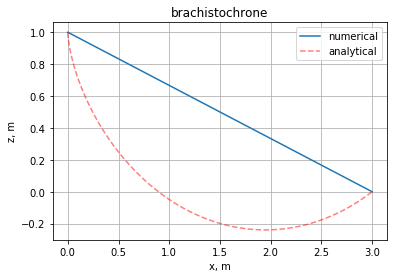

In [156]:
n_x = 100  # number of points for approximation of path
x_end = 3  # final x position when height is zero

# analytical solution
xa, ya = analytical(x_end=x_end, n_x=n_x)

# numerical solution
x, y_opt = numerical(x_end=x_end, n_x=n_x)

# plot
plt.title('brachistochrone')
plt.plot(x, y_opt, label='numerical')
plt.plot(xa, ya, 'r--', label='analytical', alpha=0.5)
plt.grid(True)
plt.xlabel('x, m')
plt.ylabel('z, m')
plt.legend()